# Competition - EEG Data Classification with three classes

Authors: Quentin Surdez, Aubry Mangold

In this notebook we will explore optimization of our precedent MLP architecture. From the first lab we noticed that the data is clearly imbalanced, we will try to oversample using the SMOTE method. We will iterate over different architecture and see which one is the most efficient for our validation.

We will also add `BatchNormalization` between layers as well as a `DropOut` of 0.3. We will also implement an early stopping mechanism so that our training does not overfit the data given.

One note is that we implemented quite a lot of optimization in the precedent exercises already such as the use of the Adam optimizer, the use of the cateegorical loss function, so maybe the impact of the SMOTE method won't be as big as if we used MSE optimizer and switched to Adam here.




## Utilities functions

We define the functions that will be used throughout this exercise in the
following cells.


In [6]:
import numpy as np
import pandas as pd

### Data transformation

We define a function to normalize our data. We use a `StandardScaler` and the
 `fit_transform()` function to fit on the same data that we will transform.
This step is crucial in the preprocessing of our data.

In [1]:
from sklearn.preprocessing import StandardScaler

def normalize_data(data_to_fit, data_to_transform):
    scaler = StandardScaler()
    scaler.fit(data_to_fit)
    data = scaler.transform(data_to_transform)
    return data

### Create the model to classify the three classes

We will create a model with 2 hidden layers. They will have 16 and 8 neurons each. We will use the relu activation function for the input and hidden layers and the softmax activation function for the output. The loss function used will be categorical cross entropy and the optimizer will be adam.


In [27]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import CategoricalAccuracy

def create_multiclass_model(num_neuron_first_hidden_layer=32, num_neuron_second_hidden_layer=16, num_neuron_third_hidden_layer=8):
  num_classes = 3
  model = Sequential()
  model.add(Input([25,]))
  model.add(Dense(num_neuron_first_hidden_layer, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(num_neuron_second_hidden_layer, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(num_neuron_third_hidden_layer, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(num_classes, activation='softmax'))  # softmax for multi-class
  
  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[CategoricalAccuracy()])
                  
  return model

md = create_multiclass_model()
md.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 32)                832       
_________________________________________________________________
batch_normalization_42 (Batc (None, 32)                128       
_________________________________________________________________
dropout_42 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_43 (Batc (None, 16)                64        
_________________________________________________________________
dropout_43 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 8)               

### Train the model 

Here is a function to train the model. The function will iterate through the
different folds and train the model on the training data and evaluate it on
the test data. It implements early stopping to reduce overfitting. We 100
epochs for the training and batch size of 32.

In [3]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping


def train_model(folds, input_data, output_data, create_model_func):
    history_list = []
    trained_mlb = []
    history = []
    for i, (train_index, test_index) in enumerate(folds):
        print(f"Fold{i+1}/3")

        # We need to create a new model everytime otherwise fit will continue previous training
        mlb = create_model_func()
        # we normalize the data
        scaler = StandardScaler()
        train_input = normalize_data(input_data[train_index],
                                input_data[train_index])
        test_input = normalize_data(input_data[train_index], input_data[test_index])

        # Early stopping is implemented to prevent overfitting
        # monitoring validation loss and stopping training when no improvement is seen for several epochs.
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        history = mlb.fit(
            x=train_input, y=output_data[train_index],
            validation_data=(test_input, output_data[test_index]),
            epochs=100,
            callbacks=[early_stopping],
            verbose=1
        )

        history_list.append(history)
        trained_mlb.append(mlb)
    return history_list, trained_mlb

### Evaluate the models

Plot the validation and training history loss. Plot the confusion matrix and the F1 scores.


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_losses(history_list):

    min_epochs = min(len(history.history['loss']) for history in history_list)

    # Extract training and validation losses, limiting to min_epochs
    train_losses = np.array([history.history['loss'][:min_epochs] for history in history_list])
    val_losses = np.array([history.history['val_loss'][:min_epochs] for history in history_list])


    # Calculate mean and standard deviation for training and validation losses
    mean_train_loss = np.mean(train_losses, axis=0)
    std_train_loss = np.std(train_losses, axis=0)
    mean_val_loss = np.mean(val_losses, axis=0)
    std_val_loss = np.std(val_losses, axis=0)

    # Plot mean and standard deviation for training loss
    plt.plot(mean_train_loss, label='Training Loss (Mean)')
    plt.fill_between(range(len(mean_train_loss)), mean_train_loss -
                     std_train_loss, mean_train_loss + std_train_loss,
                    alpha=0.3, label='Training Loss (Std)')

    # Plot mean and standard deviation for validation loss
    plt.plot(mean_val_loss, label='Validation Loss (Mean)')
    plt.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, alpha=0.3,
                    label='Validation Loss (Std)')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()

def plot_losses_per_fold(history_list):
    plt.figure(figsize=(12, 4))
    for i, history in enumerate(history_list):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.title(f'Fold {i+1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()



def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    ax =sns.heatmap(confusion_matrix.astype(int), annot=False, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["n-rem","rem","awake"], yticklabels=["n-rem","rem", "awake"], annot_kws={"size": 10})
    plt.title(title)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            x = j + 0.5  # Shift x-coordinate to center the text
            y = i + 0.5  # Shift y-coordinate to center the text
            ax.text(x, y, str(confusion_matrix[i, j]), ha="center", va="center", color="black")
    
    plt.show()
def test_model(model, test_input, test_output):
   
    # Evaluate the trained model on the test fold
    predictions = model.predict(test_input)
    true_labels = np.argmax(test_output, axis=1)  # Get the index of the maximum value as the true labels
    predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the maximum value as the predicted labels
    cm = confusion_matrix(true_labels, predicted_labels)
    # Compute confusion matrix
    f1 = f1_score(true_labels, predicted_labels, average='macro')  # Use macro averaging for multi-class classification
    return cm, f1


## Let's train our Model !

Now that we have defined our function, we can preprocess the data and train
our model on it.

### Preprocess

We first need to load and preprocess the data given.

In [7]:
# Load the data
mouse1 = pd.read_csv('pw3_data/EEG_mouse_data_1.csv')
mouse2 = pd.read_csv('pw3_data/EEG_mouse_data_2.csv')

# Combine training data
train_data = pd.concat([mouse1, mouse2], ignore_index=True)

We then extract the features that are relevant for our training.

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder



features = train_data.drop(['state'], axis=1)
labels = train_data['state']

selected_features = [
    
    'amplitude_around_1_Hertz', 'amplitude_around_2_Hertz',
    'amplitude_around_3_Hertz', 'amplitude_around_4_Hertz',

    
    'amplitude_around_5_Hertz', 'amplitude_around_6_Hertz',
    'amplitude_around_7_Hertz', 'amplitude_around_8_Hertz',

    
    'amplitude_around_9_Hertz', 'amplitude_around_10_Hertz',
    'amplitude_around_11_Hertz', 'amplitude_around_12_Hertz',
    'amplitude_around_13_Hertz',

    
    'amplitude_around_14_Hertz', 'amplitude_around_15_Hertz',
    'amplitude_around_16_Hertz', 'amplitude_around_17_Hertz',
    'amplitude_around_18_Hertz', 'amplitude_around_19_Hertz',

    
    'amplitude_around_20_Hertz', 'amplitude_around_63_Hertz',
    'amplitude_around_64_Hertz', 'amplitude_around_65_Hertz',
    'amplitude_around_66_Hertz', 'amplitude_around_67_Hertz',

]


# Choose only selected features among all the features
input_data = np.array(features[selected_features])
input_data = input_data.astype('float32')

# We transform the labels to 0, 1, 2
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # Converts to 0, 1, 2
# So that it's easier for the model
output_data = to_categorical(labels_encoded)


# Print shapes for verification
print(f"Full input data shape: {input_data.shape}")
print(f"Full output data shape: {output_data.shape}")

# Print head for verification
print(f"input head: {input_data[:1]}")
print(f"labels of interest: {output_data[6566:6570]}")
print(f"states of interest: {labels[6566:6570]}")


Full input data shape: (40863, 25)
Full output data shape: (40863, 3)
input head: [[9.12315045e-06 1.36561475e-05 1.28317988e-05 1.40247175e-05
  2.28327954e-05 8.84017481e-06 1.90881692e-05 1.07377673e-05
  1.64754074e-05 1.56260121e-05 8.32685237e-06 1.73593969e-06
  2.40920235e-06 2.99540648e-06 1.26868008e-06 1.12143096e-06
  9.57261477e-07 7.91233788e-07 2.07520975e-06 2.12542091e-06
  1.19135272e-07 1.41891476e-07 9.79704495e-08 2.39160755e-07
  1.90913752e-07]]
labels of interest: [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
states of interest: 6566    r
6567    w
6568    w
6569    n
Name: state, dtype: object


Let's oversample the data with the SMOTE method

In [31]:
from imblearn.over_sampling import SMOTE

# Create the smote engine
smote = SMOTE(random_state=42)

input_data_resampled, output_data_resampled = smote.fit_resample(input_data, output_data)

# Verification of oversampling
print(f"Shape of input_data: {input_data.shape}")
print(f"Shape of labels_oneshot: {output_data.shape}")
print(f"Shape of input_data RESAMPLED: {input_data_resampled.shape}")
print(f"Shape of labels_oneshot RESAMPLED: {output_data_resampled.shape}")


/usr/local/Caskroom/miniforge/base/envs/data_science_2025/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Shape of input_data: (40863, 25)
Shape of labels_oneshot: (40863, 3)
Shape of input_data RESAMPLED: (73080, 25)
Shape of labels_oneshot RESAMPLED: (73080, 3)


We will now train the model with a 3-fold cross validation.

In [32]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

history_list, trained_mlp = train_model(kf.split(input_data_resampled), input_data_resampled,
                                        output_data_resampled, create_multiclass_model)

Fold1/3
Epoch 1/100
1523/1523 [==============================] - 3s 2ms/step - loss: 0.7245 - categorical_accuracy: 0.6964 - val_loss: 0.4677 - val_categorical_accuracy: 0.8174
Epoch 2/100
1523/1523 [==============================] - 2s 1ms/step - loss: 0.5768 - categorical_accuracy: 0.7803 - val_loss: 0.4491 - val_categorical_accuracy: 0.8233
Epoch 3/100
1523/1523 [==============================] - 2s 1ms/step - loss: 0.5573 - categorical_accuracy: 0.7886 - val_loss: 0.4372 - val_categorical_accuracy: 0.8266
Epoch 4/100
1523/1523 [==============================] - 2s 1ms/step - loss: 0.5424 - categorical_accuracy: 0.7941 - val_loss: 0.4311 - val_categorical_accuracy: 0.8271
Epoch 5/100
1523/1523 [==============================] - 2s 1ms/step - loss: 0.5319 - categorical_accuracy: 0.7972 - val_loss: 0.4261 - val_categorical_accuracy: 0.8280
Epoch 6/100
1523/1523 [==============================] - 2s 1ms/step - loss: 0.5244 - categorical_accuracy: 0.8010 - val_loss: 0.4204 - val_categor

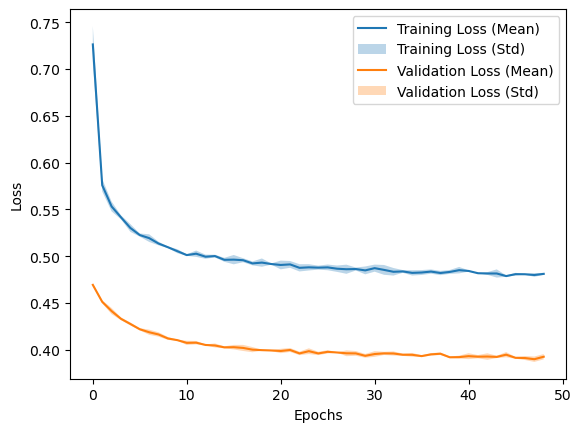

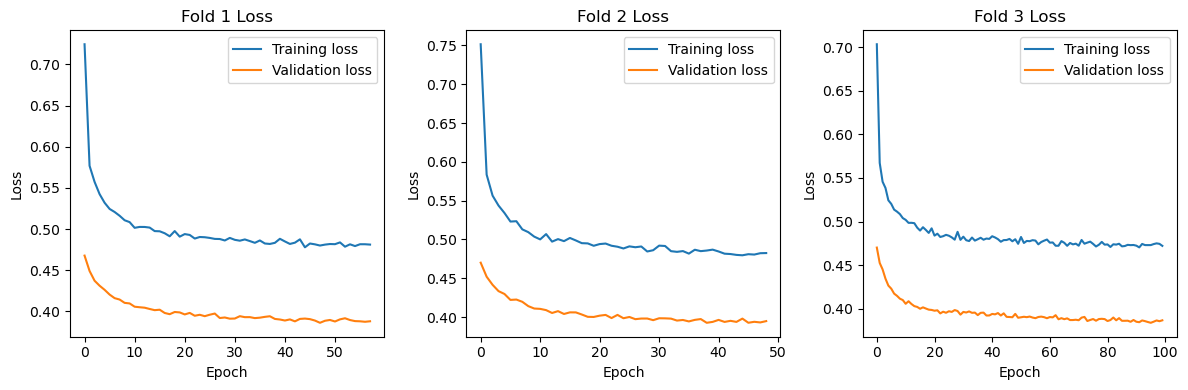

In [33]:
plot_losses(history_list)

plot_losses_per_fold(history_list)

Plot the confusion matrix and F1-score

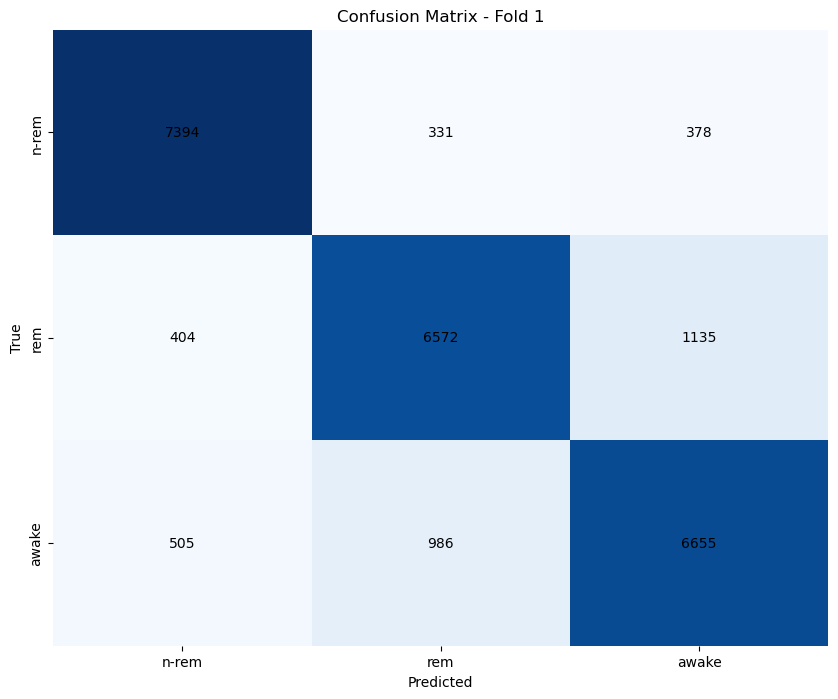

F1 Score - Fold 1: 0.84624707339051


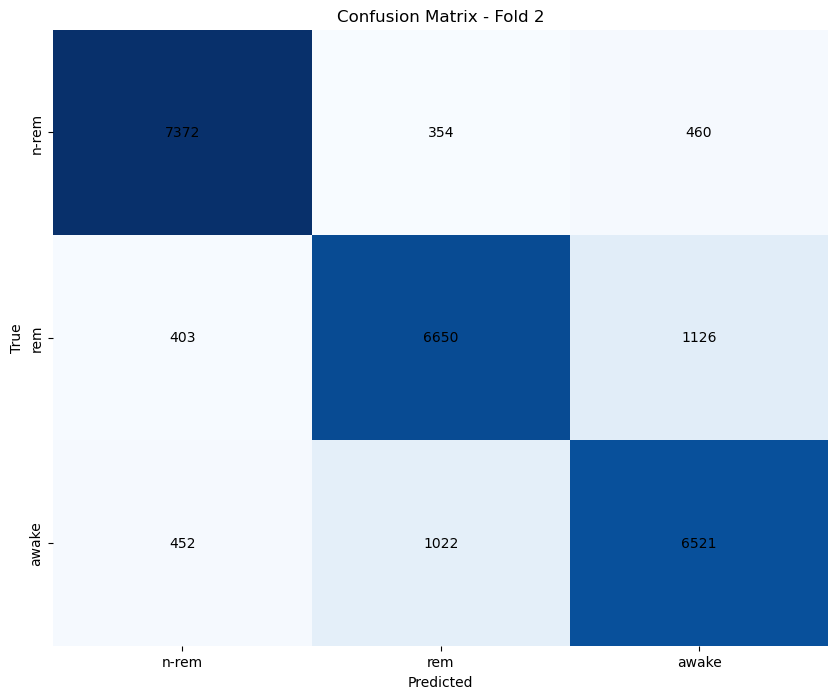

F1 Score - Fold 2: 0.8430027167097345


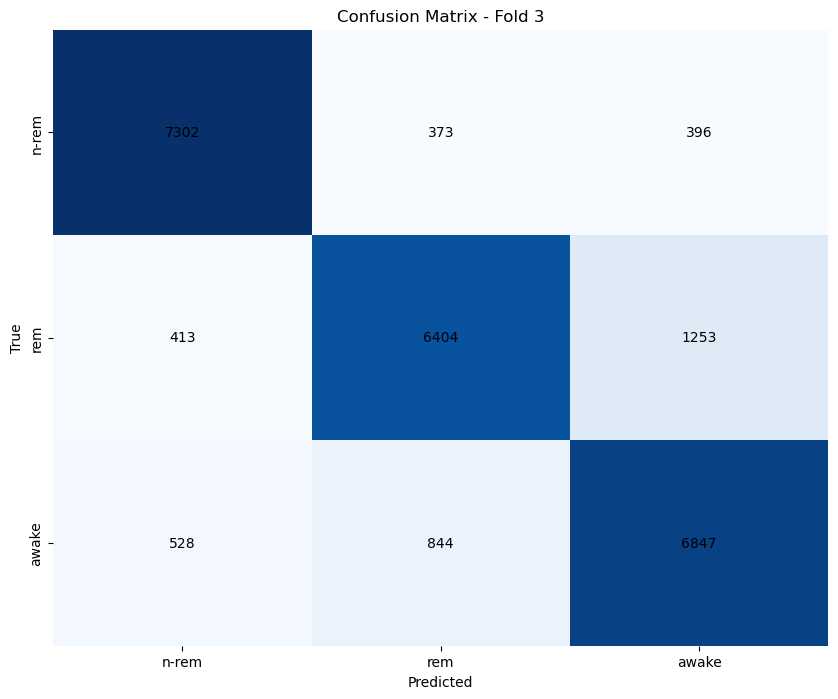

F1 Score - Fold 3: 0.8435700955587307


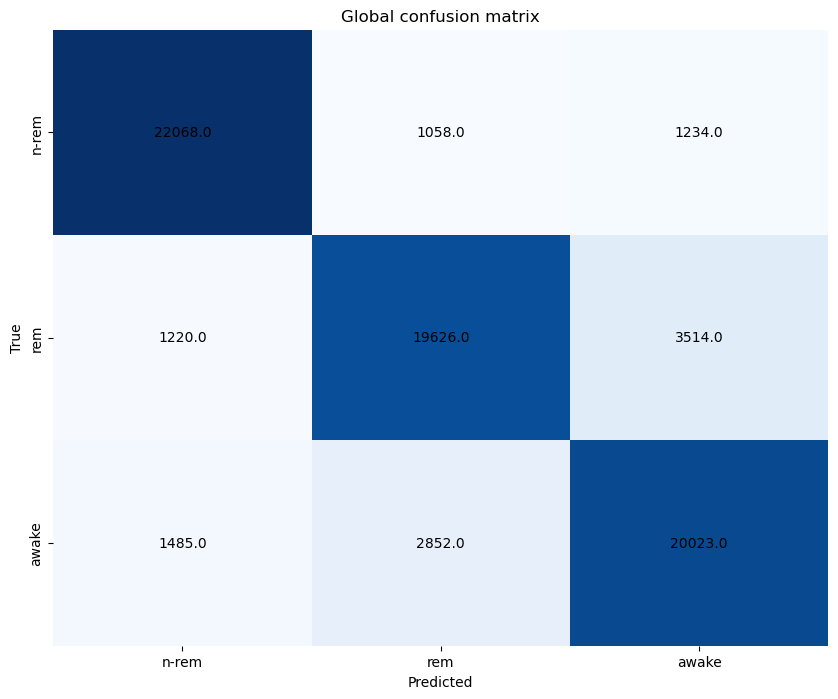

Mean F1 Score across all folds: 0.8442732952196584


In [34]:
f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))


for i, (train_index, test_index) in enumerate(kf.split(input_data_resampled)):
    test_data = normalize_data(input_data_resampled[train_index], input_data_resampled[test_index])
    cm, f1 = test_model(trained_mlp[i], test_data, output_data_resampled[test_index])
    
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')
    mean_confusion_matrix += cm
    
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")
   
    
# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

## It's now time to choose amongst the best model ! 

Now that we have trained the model and that we have their F1 Score, we will have to choose the best one and make it predict the classes fro the test dataset.


In [59]:
best_model = np.argmax(f1_scores)
print(f"Best model: {best_model}")
print(f"Best f1 score: {f1_scores[best_model]}")

Best model: 0
Best f1 score: 0.84624707339051


Let's preprocess our test data the same way we did our training data

In [66]:
data_test = pd.read_csv('pw3_data/EEG_mouse_data_test.csv')
data_test_selected = np.array(data_test[selected_features])

# Normalizing the data and fit from the input data not the test one to reproduce 
# Learning environment
data_test_normalized = normalize_data(input_data_resampled, data_test_selected)

# Getting the predictions from the best model
predictions = trained_mlp[best_model].predict(data_test_normalized)

print(f"Predictions: {predictions}")

# Finding the label from the probability vector 
predicted_labels_from_vector = np.argmax(predictions, axis=1)

print(f"Predicteed classes: {predicted_labels_from_vector}")

# Getting the label back
predicted_labels = label_encoder.inverse_transform(predicted_labels_from_vector)

print(f"Predicted labels: {predicted_labels}")

predicated_labels_array = np.array(predicted_labels)

print(f"Predicted array: {predicated_labels_array}")

with open("test_pred.npy", "wb") as f:
  np.save(f, predicated_labels_array)

Predictions: [[9.9589443e-01 8.1047293e-04 3.2951212e-03]
 [7.3064190e-01 5.9782695e-02 2.0957536e-01]
 [9.1891271e-01 9.5132776e-03 7.1574003e-02]
 ...
 [4.8133782e-01 8.7388948e-02 4.3127325e-01]
 [4.3181124e-01 2.5039339e-01 3.1779537e-01]
 [1.9873271e-02 8.7060146e-02 8.9306653e-01]]
Predicteed classes: [0 0 0 ... 0 0 2]
Predicted labels: ['n' 'n' 'n' ... 'n' 'n' 'w']
Predicted array: ['n' 'n' 'n' ... 'n' 'n' 'w']
